In [0]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
# imports related to model building and evaluation
from pyspark.ml import Pipeline, Estimator, Transformer, Model, PipelineModel
import pyspark.ml.feature as MFT
import pyspark.ml.functions as MF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# first attempt to build a model (whole code given)
import seaborn as sns
df = sns.load_dataset('iris')

# binary classification
df_binary = df.assign(species=df['species'].where(df['species']=='virginica', 'not virginica'))
df_binary = spark.createDataFrame(df_binary)

# pack the features into a vector (this is a transformer)
# we do not use all features to allow some room for model tuning
# feature_assembler = MFT.VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
feature_assembler = MFT.VectorAssembler(inputCols=['sepal_width', 'petal_width'], outputCol='features')

# create a min max scaler (this is an estimator)
minMax_scaler = MFT.MinMaxScaler(min=0., max=1., inputCol='features', outputCol='features_scaled')

# string indexer (this is a transformer)
labels = ["not virginica", "virginica"]
fromlabelsModel = MFT.StringIndexerModel.from_labels(labels,
                                                     inputCol="species", outputCol="species_indexed",
                                                     handleInvalid="error")

# create a binomial logistic regression model (this is an estimator)
lr = LogisticRegression(featuresCol='features_scaled', labelCol='species_indexed', predictionCol='prediction')

# build the pipeline
pipeline = Pipeline(stages=[feature_assembler, minMax_scaler, fromlabelsModel, lr])

# cache the dataset to ensure deterministic behaviour and ensure fast model fitting
df_binary.cache()
train, test = df_binary.randomSplit([0.2, 0.8], seed=8)

# fit the model
pipeline_model = pipeline.fit(train)

# apply the model to the test set
results = pipeline_model.transform(test)
results = MFT.IndexToString(inputCol='prediction', outputCol='species_predicted', labels=labels).transform(results)

In [0]:
results.select('prediction','species_indexed','species','species_predicted').show(100,truncate = False)

+----------+---------------+-------------+-----------------+
|prediction|species_indexed|species      |species_predicted|
+----------+---------------+-------------+-----------------+
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0            |not virginica|not virginica    |
|0.0       |0.0         

In [0]:
results.groupBy('species').pivot('species_predicted').count().show()

+-------------+-------------+---------+
|      species|not virginica|virginica|
+-------------+-------------+---------+
|    virginica|            2|       38|
|not virginica|           80|        3|
+-------------+-------------+---------+



In [0]:
confusion_matrix = (results.groupby('species').pivot('species_predicted').count().toPandas()
                    .set_index('species').sort_index(axis='index', ascending=False).sort_index(axis='columns', ascending=False)
                    .fillna(0).astype(int)
                    )

Text(50.72222222222221, 0.5, 'True value')

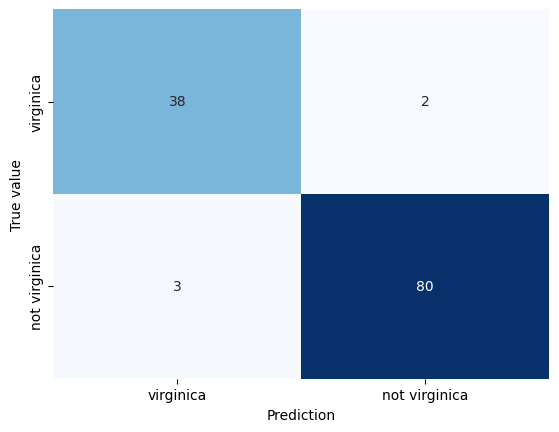

In [0]:
ax = sns.heatmap(confusion_matrix, cmap='Blues', annot=True, cbar=False)
ax.set_xlabel('Prediction')
ax.set_ylabel('True value')

In [0]:
lr_model = pipeline_model.stages[-1]
metrics = lr_model.evaluate(results.select('features_scaled', 'species_indexed'))

print(f'Recall, sensitivity or true positive rate {metrics.recallByLabel[1]:.4f}')
print(f'Precision or positive predictive value {metrics.precisionByLabel[1]:.4f}')
print(f'Specificity or true negative rate {1-metrics.falsePositiveRateByLabel[1]:.4f}')
print(f'False positive rate or (1 - specificity) {metrics.falsePositiveRateByLabel[1]:.4f}')
# Recall, sensitivity or true positive rate 0.9167
# Precision or positive predictive value 0.8919
# Specificity or true negative rate 0.9506
# False positive rate or (1 - specificity) 0.0494


Recall, sensitivity or true positive rate 0.9500
Precision or positive predictive value 0.9268
Specificity or true negative rate 0.9639
False positive rate or (1 - specificity) 0.0361


In [0]:
evaluator = BinaryClassificationEvaluator(labelCol='species_indexed', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
areaUnderROC = evaluator.evaluate(results.select('species_indexed', 'rawPrediction'))

print(f'The area under the ROC curve for the test set is {areaUnderROC:.4f}')
# The area under the ROC curve for the test set is 0.9933

The area under the ROC curve for the test set is 0.9967


In [0]:
# cross validation and fine tuning
# complete code, incuding cross-validation
import seaborn as sns
df = sns.load_dataset('iris')

# binary classification
df_binary = df.assign(species=df['species'].where(df['species']=='virginica', 'not virginica'))
df_binary = spark.createDataFrame(df_binary)

# cache the dataset to ensure deterministic behaviour and ensure fast model fitting
df_binary.cache()
train, test = df_binary.randomSplit([0.6, 0.4], seed=8)

# pack the features into a vector (this is a transformer)
feature_assembler = MFT.VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')

# create a min max scaler (this is an estimator)
minMax_scaler = MFT.MinMaxScaler(min=0., max=1., inputCol='features', outputCol='features_scaled')

# string indexer (this is a transformer)
labels = ["not virginica", "virginica"]
fromlabelsModel = MFT.StringIndexerModel.from_labels(labels,
                                                     inputCol="species", outputCol="species_indexed",
                                                     handleInvalid="error")

# create a binomial logistic regression model (this is an estimator)
lr = LogisticRegression(featuresCol='features_scaled', labelCol='species_indexed', predictionCol='prediction')

# build the pipeline
pipeline = Pipeline(stages=[feature_assembler, minMax_scaler, fromlabelsModel, lr])

# build the parameter map (grid)
from itertools import combinations, chain
from pprint import pprint
from time import time
cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
cols_combinations = list(chain(combinations(cols, 2), combinations(cols, 3), combinations(cols, 4)))
pprint(cols_combinations)
# [('sepal_length', 'sepal_width'),
#  ('sepal_length', 'petal_length'),
#  ('sepal_length', 'petal_width'),
#  ('sepal_width', 'petal_length'),
#  ('sepal_width', 'petal_width'),
#  ('petal_length', 'petal_width'),
#  ('sepal_length', 'sepal_width', 'petal_length'),
#  ('sepal_length', 'sepal_width', 'petal_width'),
#  ('sepal_length', 'petal_length', 'petal_width'),
#  ('sepal_width', 'petal_length', 'petal_width'),
#  ('sepal_length', 'sepal_width', 'petal_length', 'petal_width')]
param_grid = (ParamGridBuilder()
              .addGrid(lr.elasticNetParam, [0., 0.5, 1.])
              .addGrid(lr.regParam, [0., 0.1, 1., 2., 5.])
              .addGrid(feature_assembler.inputCols, cols_combinations)
              .build())

# evaluate the model performance
evaluator = BinaryClassificationEvaluator(labelCol='species_indexed', rawPredictionCol='rawPrediction', metricName='areaUnderROC')

# setup the cross validation estimator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=4,
                    seed=8,
                    collectSubModels=True)

# fit the model using cross-validation and grid search
start_time = time()
cv_model = cv.fit(train)

print(f'Hyper-parameter tuning using 4-fold validation took {time()-start_time: 0.2f} sec')

[('sepal_length', 'sepal_width'),
 ('sepal_length', 'petal_length'),
 ('sepal_length', 'petal_width'),
 ('sepal_width', 'petal_length'),
 ('sepal_width', 'petal_width'),
 ('petal_length', 'petal_width'),
 ('sepal_length', 'sepal_width', 'petal_length'),
 ('sepal_length', 'sepal_width', 'petal_width'),
 ('sepal_length', 'petal_length', 'petal_width'),
 ('sepal_width', 'petal_length', 'petal_width'),
 ('sepal_length', 'sepal_width', 'petal_length', 'petal_width')]
Hyper-parameter tuning using 4-fold validation took  4483.65 sec


In [0]:
# obtain the best model and the optimised hyper-parameters
best_model = cv_model.bestModel
print(f'features maintained in the best model {best_model.stages[0].getInputCols()}')
print(f'elastic net parameter in the best model {best_model.stages[-1].getElasticNetParam()}')
print(f'regularization parameter in the best model {best_model.stages[-1].getRegParam()}')
# features maintained in the best model ['sepal_width', 'petal_width']
# elastic net parameter in the best model 0.0
# regularization parameter in the best model 0.0

# apply the model to the training set
results = best_model.transform(train)
results = MFT.IndexToString(inputCol='prediction', outputCol='species_predicted', labels=labels).transform(results)

# compute the confusion matrix manually (for the training set)
confusion_matrix = (results.groupby('species').pivot('species_predicted').count().toPandas()
                    .set_index('species').sort_index(axis='index', ascending=False).sort_index(axis='columns', ascending=False)
                    .fillna(0).astype(int)
                    )
print(confusion_matrix)
#                virginica  not virginica
# species  
# 
# # obtain the best model and the optimised hyper-parameters
best_model = cv_model.bestModel
print(f'features maintained in the best model {best_model.stages[0].getInputCols()}')
print(f'elastic net parameter in the best model {best_model.stages[-1].getElasticNetParam()}')
print(f'regularization parameter in the best model {best_model.stages[-1].getRegParam()}')
# features maintained in the best model ['sepal_width', 'petal_width']
# elastic net parameter in the best model 0.0
# regularization parameter in the best model 0.0

# apply the model to the training set
results = best_model.transform(train)
results = MFT.IndexToString(inputCol='prediction', outputCol='species_predicted', labels=labels).transform(results)

# compute the confusion matrix manually (for the training set)
confusion_matrix = (results.groupby('species').pivot('species_predicted').count().toPandas()
                    .set_index('species').sort_index(axis='index', ascending=False).sort_index(axis='columns', ascending=False)
                    .fillna(0).astype(int)
                    )
print(confusion_matrix)
# retrieve the coefficients
results = best_model.transform(train)
results = MFT.IndexToString(inputCol='prediction', outputCol='species_predicted', labels=labels).transform(results)
coef_names = ['intercept'] + [x['name'] for x in results.schema['features'].metadata['ml_attr']['attrs']['numeric']]
coef_values = [best_model.stages[-1].intercept] + list(best_model.stages[-1].coefficients)
coefs = pd.Series(coef_values, index=coef_names)

print(coefs)
results = results.select('features_scaled', 'species', 'species_predicted')
results = results.withColumn('sepal_width_scaled', MF.vector_to_array(F.col('features_scaled'))[0])
results = results.withColumn('petal_width_scaled', MF.vector_to_array(F.col('features_scaled'))[1])
results_pd = results.select('sepal_width_scaled', 'petal_width_scaled', 'species', 'species_predicted').toPandas()

ax = sns.scatterplot(data=results_pd, x='sepal_width_scaled', y='petal_width_scaled', hue='species')
xs = np.linspace(results_pd['sepal_width_scaled'].min(), results_pd['sepal_width_scaled'].max(), 3)
ys = (-coefs['intercept'] - coefs['sepal_width']*xs)/coefs['petal_width']
sns.lineplot(x=xs, y=ys, ax=ax)
ax.lines[0].set_linestyle("--")
ax.lines[0].set_color("k")
ax.set_xlabel('sepal width (scaled)')
ax.set_ylabel('petal width (scaled)')                             

In [0]:
# multinomial logistic regression
import seaborn as sns
df = sns.load_dataset('iris')

# binary classification
df_multinomial = spark.createDataFrame(df)

# pack the features into a vector (this is a transformer)
feature_assembler = MFT.VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')

# create a min max scaler (this is an estimator)
minMax_scaler = MFT.MinMaxScaler(min=0., max=1., inputCol='features', outputCol='features_scaled')

# string indexer (this is a transformer)
labels = ['setosa', 'versicolor', 'virginica']
fromlabelsModel = MFT.StringIndexerModel.from_labels(labels,
                                                     inputCol="species", outputCol="species_indexed",
                                                     handleInvalid="error")

# create a binomial logistic regression model (this is an estimator)
lr = LogisticRegression(featuresCol='features_scaled', labelCol='species_indexed', predictionCol='prediction')

# build the pipeline
pipeline = Pipeline(stages=[feature_assembler, minMax_scaler, fromlabelsModel, lr])

# cache the dataset to ensure deterministic behaviour and ensure fast model fitting
df_multinomial.cache()
train, test = df_multinomial.randomSplit([0.8, 0.2], seed=8)

# fit the model
pipeline_model = pipeline.fit(train)

# apply the model to the test set
results = pipeline_model.transform(test)
results = MFT.IndexToString(inputCol='prediction', outputCol='species_predicted', labels=labels).transform(results)

# compute the confusion matrix manually (for the test set)
confusion_matrix = (results.groupby('species').pivot('species_predicted').count().toPandas()
                    .set_index('species').sort_index(axis='index', ascending=False).sort_index(axis='columns', ascending=False)
                    .fillna(0).astype(int)
                    )
print(confusion_matrix)